### IMAS MOORING MANUAL QC PLOTTING AND AUTOMATED QC
#### This notebook loads one netcdf file from IMOS threads and then we create a plot of the temperature time series with masked manual qc values on top. 

In [88]:
import numpy as np
import fsspec
from fsspec.core import url_to_fs
import xarray as xr
import pandas as pd
import s3fs
from dask import bag as db
import matplotlib.pyplot as plt
%matplotlib inline  

## Loading data from the SA moorings that only have hourly products for temperature 

In [141]:
#load all files from a buoy folder
fs = fsspec.filesystem('s3',use_listings_cache=False,anon=True,)

ref_files = fs.glob('s3::imos-data/IMOS/ANMN/SA/SAM7DS/hourly_timeseries/IMOS_ANMN-SA_STZ_20091215_SAM7DS_FV02_hourly-timeseries_END-20140312_C-20220622.nc')
ref_files[0:5]

#fileName = "https://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/SA/SAM7DS/hourly_timeseries/IMOS_ANMN-SA_STZ_20091215_SAM7DS_FV02_hourly-timeseries_END-20140312_C-20220622.nc"
#nc = xr.open_dataset(fileName)


['imos-data/IMOS/ANMN/SA/SAM7DS/hourly_timeseries/IMOS_ANMN-SA_STZ_20091215_SAM7DS_FV02_hourly-timeseries_END-20140312_C-20220622.nc']

In [143]:
#sort all files
ref_files = np.sort(ref_files)

#extract the unique file ID
files = [ref_files[i].split('/')[6].split('-')[2] for i in range(len(ref_files))]
files = np.unique(files)

#create an empty list
first_ref_files = []

#loop through eacy unique file ID
for i in range(len(files)):
    
    #filter all the files with that ID
    filtered_list = filter(lambda file: file.split('/')[6].split('-')[2] == files[i], ref_files)
    filtered_list = sorted(filtered_list)
    #select just the first one
    first = next(iter(filtered_list), None)
    #add file name to list
    first_ref_files.append(first)
    
first_ref_files[0:5]

['imos-data/IMOS/ANMN/SA/SAM7DS/hourly_timeseries/IMOS_ANMN-SA_STZ_20091215_SAM7DS_FV02_hourly-timeseries_END-20140312_C-20220622.nc']

### Here, I am checking the dimensions of the hourly timeseries

In [145]:
#create function to open file
def open_cdt(url):
    s3 = s3fs.S3FileSystem(anon=True,default_fill_cache=False,default_cache_type=None)
    with s3.open(url,) as f:
        data=xr.open_dataset(f,engine='h5netcdf').load().squeeze()
        #data['TEMP'] = data['TEMP'][data.TEMP_quality_control==1]
    return data


#loop through and open all files
b = db.from_sequence(first_ref_files)
cast = db.map(open_cdt,b).compute()

In [146]:
#join the files based on shared coordinates
commonvars = list(set.intersection(*list((map(lambda x:set([i for i in x.data_vars]),cast)))))
cast = [ds[commonvars] for ds in cast]

In [161]:
cast

[<xarray.Dataset>
 Dimensions:           (OBSERVATION: 42494, INSTRUMENT: 7)
 Coordinates:
     TIME              (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 20...
     LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
     LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
     NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
 Dimensions without coordinates: OBSERVATION, INSTRUMENT
 Data variables: (12/23)
     TEMP_min          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
     PRES_REL_count    (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
     PRES_REL_std      (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
     PRES_REL_max      (OBSERVATION) float32 416.5 416.8 416.5 ... 511.8 511.1
     PSAL_count        (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
     DEPTH_count       (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
     ...                .

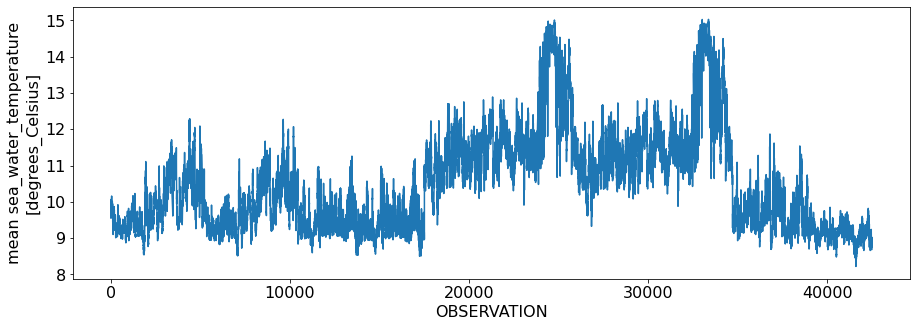

In [149]:
#combine all files into one
c =xr.concat(cast,dim='OBSERVATION')
c.TEMP.plot(x = 'OBSERVATION')

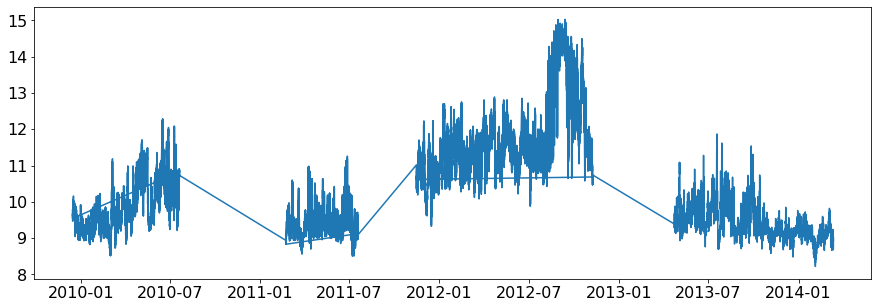

In [159]:
plt.plot(c.TIME,c.TEMP)

### Then, a plot of the hourly timeseries without any alterations

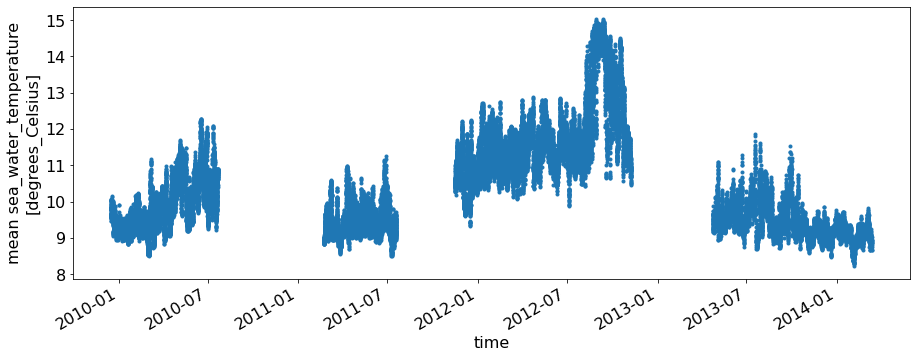

In [160]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams.update({'font.size': 16})
nc.TEMP.plot(x = 'TIME',linestyle='none',marker='.')

### Now I am going to create a daily mean product and plot it as well

In [105]:
SAM500_h

<xarray.Dataset>
Dimensions:           (OBSERVATION: 42494, INSTRUMENT: 7)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 20...
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/23)
    instrument_index  (OBSERVATION) int32 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6
    instrument_id     (INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-WORKHORSE-LON...
    source_file       (INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Velocity/IMOS_A...
    DEPTH             (OBSERVATION) float32 413.0 413.3 413.0 ... 507.4 506.8
    DEPTH_count       (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    DEPTH_min         (OBSERVATION) float32 413.0 413.3 413.0 ... 507.4 506.8
    ...                ...
    PSAL_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
    TEMP              (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_count        (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TEMP_max          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_min          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2014-03-12T20:00:00Z
    time_coverage_start:           2009-12-15T08:00:00Z
    title:                         Long time series Hourly Aggregated product...
    DODS.strlen:                   256
    DODS.dimName:                  string256

In [109]:
df = pd.DataFrame({'instrument_index': nc.instrument_index, 
                   'TIME': nc.TIME, 
                   'TEMP': nc.TEMP, 
                   'PSAL': nc.PSAL, 
                   'DEPTH': nc.DEPTH})

df.describe()

,instrument_index,TEMP,PSAL,DEPTH
count,42494.000000,42494.000000,17361.000000,42494.000000
mean,3.457923,10.493112,34.890038,421.765472
std,2.032623,1.333592,0.247405,70.505821
min,0.000000,8.220000,34.030861,343.873535
25%,2.000000,9.380000,34.676662,349.905998
50%,4.000000,10.161230,34.875225,413.052887
75%,5.000000,11.330000,35.024540,507.505432
max,6.000000,15.028605,35.932823,517.792603


In [134]:
df_grouped = df.groupby('instrument_index')

In [139]:
df

,instrument_index,TIME,TEMP,PSAL,DEPTH
0,0,2009-12-15 08:00:00,9.78,NaN,412.998413
1,0,2009-12-15 09:00:00,9.68,NaN,413.323334
2,0,2009-12-15 10:00:00,9.63,NaN,412.987488
3,0,2009-12-15 11:00:00,9.62,NaN,413.642365
4,0,2009-12-15 12:00:00,9.62,NaN,413.416443
...,...,...,...,...,...
42489,6,2014-03-12 16:00:00,8.75,NaN,507.855865
42490,6,2014-03-12 17:00:00,8.85,NaN,507.692993
42491,6,2014-03-12 18:00:00,9.03,NaN,507.686920
42492,6,2014-03-12 19:00:00,8.89,NaN,507.409302


ValueError: too many values to unpack (expected 2)

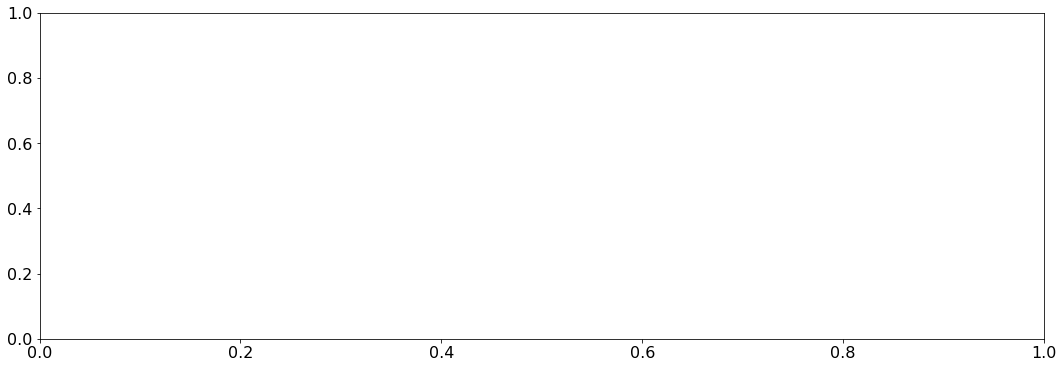

In [133]:
fig, ax = plt.subplots(figsize=(18,6))

for name, group in df_grouped:
    group.plot(x='TIME', y='TEMP', ax=ax, label=name)

ax.get_legend().remove()
plt.show()

In [114]:
SAM500_h.TEMP.where(SAM500_h.instrument_index == 0, drop=True)

<xarray.DataArray 'TEMP' (OBSERVATION: 5228)>
array([ 9.78,  9.68,  9.63, ..., 10.88, 10.83, 10.83], dtype=float32)
Coordinates:
    TIME     (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 2010-07-21T...
Dimensions without coordinates: OBSERVATION
Attributes:
    ancillary_variables:  TEMP_min TEMP_max TEMP_std TEMP_count
    long_name:            mean sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degrees_Celsius
    valid_max:            40.0
    valid_min:            -2.5
    cell_methods:         TIME:mean (interval: 1 hr comment: time mid point)

In [72]:
asd = SAM500_h.expand_dims({'INSTRUMENT_INDEX': SAM500_h.instrument_index})

In [116]:
asd = SAM500_h.set_index({'OBSERVATION':'TIME'})
asd = asd.rename({'OBSERVATION':'TIME'})
asd

<xarray.Dataset>
Dimensions:           (TIME: 42494, INSTRUMENT: 7)
Coordinates:
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
  * TIME              (TIME) datetime64[ns] 2009-12-15T08:00:00 ... 2014-03-1...
Dimensions without coordinates: INSTRUMENT
Data variables: (12/23)
    instrument_index  (TIME) int32 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6 6
    instrument_id     (INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-WORKHORSE-LON...
    source_file       (INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Velocity/IMOS_A...
    DEPTH             (TIME) float32 413.0 413.3 413.0 ... 507.7 507.4 506.8
    DEPTH_count       (TIME) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    DEPTH_min         (TIME) float32 413.0 413.3 413.0 ... 507.7 507.4 506.8
    ...                ...
    PSAL_std          (TIME) float32 nan nan nan nan nan ... nan nan nan nan nan
    TEMP              (TIME) float32 9.78 9.68 9.63 9.62 ... 8.85 9.03 8.89 8.92
    TEMP_count        (TIME) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    TEMP_max          (TIME) float32 9.78 9.68 9.63 9.62 ... 8.85 9.03 8.89 8.92
    TEMP_min          (TIME) float32 9.78 9.68 9.63 9.62 ... 8.85 9.03 8.89 8.92
    TEMP_std          (TIME) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2014-03-12T20:00:00Z
    time_coverage_start:           2009-12-15T08:00:00Z
    title:                         Long time series Hourly Aggregated product...
    DODS.strlen:                   256
    DODS.dimName:                  string256

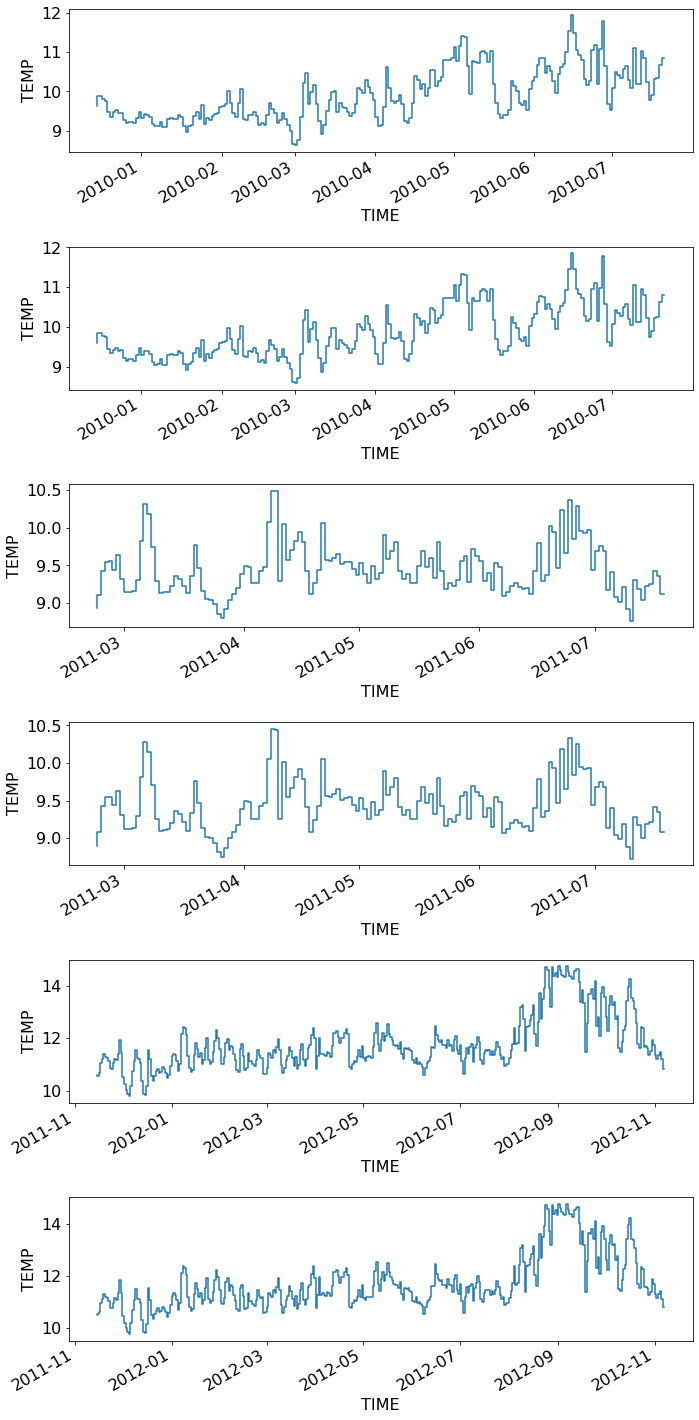

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(asd.instrument_index.max().item(), figsize=(10, 20), sharex=False)
for i in range(asd.instrument_index.max().item()):
    asd.TEMP.where(asd.instrument_index == i, drop=True).resample({'TIME':'D'}).mean().plot.step(ax=ax[i])
plt.tight_layout()

In [91]:
SAM500_h.TEMP.shape

(42494,)

In [98]:
temp = SAM500_h.TIME.to_dataframe()

In [104]:
np.unique(temp.iloc[:, 0]).shape

(25135,)

In [87]:
SAM500_h.groupby('instrument_index').groups[0]#.sortby(SAM500_h.TIME).resample({'TIME':'D'})

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [76]:
asd.TEMP.sel(INSTRUMENT_INDEX=1).sortby(SAM500_h.TIME).resample({'TIME':'D'})


ValueError: Dimensions {'OBSERVATION'} do not exist. Expected one or more of Frozen({'INSTRUMENT_INDEX': 5229, 'TIME': 42494})

In [63]:
SAM500_h.INSTRUMENT

<xarray.DataArray 'INSTRUMENT' (INSTRUMENT: 7)>
array([0, 1, 2, 3, 4, 5, 6])
Coordinates:
    LONGITUDE      (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8 135.8
    LATITUDE       (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH  (INSTRUMENT) float32 414.5 423.3 514.1 ... 347.9 353.0 509.7
Dimensions without coordinates: INSTRUMENT

In [61]:
SAM500_h.expand_dims({'instrument':SAM500_h.instrument_index})

<xarray.Dataset>
Dimensions:           (OBSERVATION: 42494, INSTRUMENT: 7, instrument: 42494)
Coordinates:
  * instrument        (instrument) int32 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    TIME              (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 20...
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/23)
    instrument_index  (instrument, OBSERVATION) int32 0 0 0 0 0 0 ... 6 6 6 6 6
    instrument_id     (instrument, INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-W...
    source_file       (instrument, INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Vel...
    DEPTH             (instrument, OBSERVATION) float32 413.0 413.3 ... 506.8
    DEPTH_count       (instrument, OBSERVATION) float32 1.0 1.0 1.0 ... 1.0 1.0
    DEPTH_min         (instrument, OBSERVATION) float32 413.0 413.3 ... 506.8
    ...                ...
    PSAL_std          (instrument, OBSERVATION) float32 nan nan nan ... nan nan
    TEMP              (instrument, OBSERVATION) float32 9.78 9.68 ... 8.89 8.92
    TEMP_count        (instrument, OBSERVATION) float32 1.0 1.0 1.0 ... 1.0 1.0
    TEMP_max          (instrument, OBSERVATION) float32 9.78 9.68 ... 8.89 8.92
    TEMP_min          (instrument, OBSERVATION) float32 9.78 9.68 ... 8.89 8.92
    TEMP_std          (instrument, OBSERVATION) float32 nan nan nan ... nan nan
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2014-03-12T20:00:00Z
    time_coverage_start:           2009-12-15T08:00:00Z
    title:                         Long time series Hourly Aggregated product...
    DODS.strlen:                   256
    DODS.dimName:                  string256

In [50]:
c_day = SAM500_h.set_index({'OBSERVATION':'TIME'})


In [42]:
c_day.drop([])

<xarray.Dataset>
Dimensions:           (OBSERVATION: 42494, INSTRUMENT: 7)
Coordinates:
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
  * OBSERVATION       (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 20...
Dimensions without coordinates: INSTRUMENT
Data variables: (12/23)
    instrument_index  (OBSERVATION) int32 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6
    instrument_id     (INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-WORKHORSE-LON...
    source_file       (INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Velocity/IMOS_A...
    DEPTH             (OBSERVATION) float32 413.0 413.3 413.0 ... 507.4 506.8
    DEPTH_count       (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    DEPTH_min         (OBSERVATION) float32 413.0 413.3 413.0 ... 507.4 506.8
    ...                ...
    PSAL_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
    TEMP              (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_count        (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TEMP_max          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_min          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2014-03-12T20:00:00Z
    time_coverage_start:           2009-12-15T08:00:00Z
    title:                         Long time series Hourly Aggregated product...
    DODS.strlen:                   256
    DODS.dimName:                  string256

In [43]:
#resample to calculate daily means
c_day = c_day.sortby(SAM500_h.OBSERVATION).resample({'OBSERVATION':  'M'}).mean()
c_day.TEMP.plot(x = 'TIME')

ValueError: cannot reindex or align along dimension 'OBSERVATION' because the index has duplicate values

#### INTERPOLATE THE DATA

In [28]:
#interpolate the missing data
c_inter = SAM500_h.interpolate_na(dim=('TIME'), method='linear')
#resample to calculate the monthly means
#c_month = c_inter.resample(TIME = 'MS').mean()
#c_month.TEMP.plot(x = "TIME")

In [29]:
c_inter

<xarray.Dataset>
Dimensions:           (OBSERVATION: 42494, INSTRUMENT: 7)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 20...
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/23)
    instrument_index  (OBSERVATION) int32 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6
    instrument_id     (INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-WORKHORSE-LON...
    source_file       (INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Velocity/IMOS_A...
    DEPTH             (OBSERVATION) float32 413.0 413.3 413.0 ... 507.4 506.8
    DEPTH_count       (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    DEPTH_min         (OBSERVATION) float32 413.0 413.3 413.0 ... 507.4 506.8
    ...                ...
    PSAL_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
    TEMP              (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_count        (OBSERVATION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TEMP_max          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_min          (OBSERVATION) float32 9.78 9.68 9.63 ... 9.03 8.89 8.92
    TEMP_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2014-03-12T20:00:00Z
    time_coverage_start:           2009-12-15T08:00:00Z
    title:                         Long time series Hourly Aggregated product...
    DODS.strlen:                   256
    DODS.dimName:                  string256

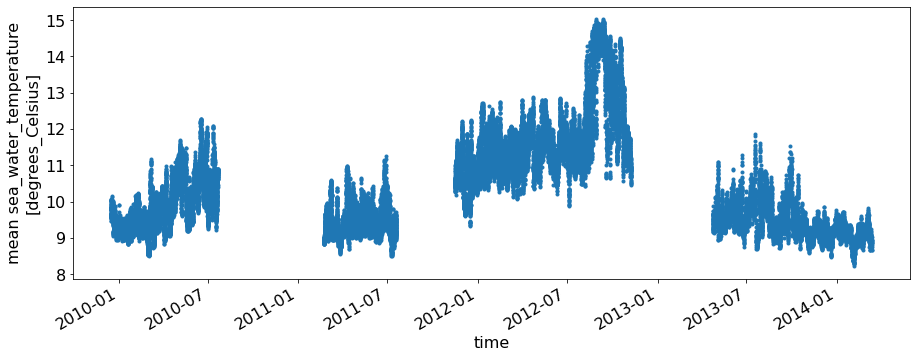

In [24]:
c_inter.TEMP.plot(x = 'TIME',linestyle='none',marker='.')

In [22]:
#resample to calculate daily means
c_day = SAM500_h.sortby(SAM500_h.TIME).resample(OBSERVATION='D').mean()
#c_day.TEMP.plot(x = 'TIME')

KeyError: 'OBSERVATION'

In [16]:
c_day

<xarray.Dataset>
Dimensions:           (OBSERVATION: 42494, INSTRUMENT: 7)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] 2009-12-15T08:00:00 ... 20...
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/23)
    instrument_index  (OBSERVATION) int32 0 1 0 1 0 1 0 1 0 ... 6 6 6 6 6 6 6 6
    instrument_id     (INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-WORKHORSE-LON...
    source_file       (INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Velocity/IMOS_A...
    DEPTH             (OBSERVATION) float32 413.0 419.6 413.3 ... 507.4 506.8
    DEPTH_count       (OBSERVATION) float32 1.0 111.0 1.0 111.0 ... 1.0 1.0 1.0
    DEPTH_min         (OBSERVATION) float32 413.0 419.6 413.3 ... 507.4 506.8
    ...                ...
    PSAL_std          (OBSERVATION) float32 nan 0.0005537 nan ... nan nan nan
    TEMP              (OBSERVATION) float32 9.78 9.542 9.68 ... 9.03 8.89 8.92
    TEMP_count        (OBSERVATION) float32 1.0 111.0 1.0 111.0 ... 1.0 1.0 1.0
    TEMP_max          (OBSERVATION) float32 9.78 9.543 9.68 ... 9.03 8.89 8.92
    TEMP_min          (OBSERVATION) float32 9.78 9.541 9.68 ... 9.03 8.89 8.92
    TEMP_std          (OBSERVATION) float32 nan 0.0004594 nan ... nan nan nan
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2014-03-12T20:00:00Z
    time_coverage_start:           2009-12-15T08:00:00Z
    title:                         Long time series Hourly Aggregated product...
    DODS.strlen:                   256
    DODS.dimName:                  string256

In [165]:
SAM500_m=SAM500_h.groupby('TIME.day').mean('OBSERVATION')

In [166]:
SAM500_m

<xarray.Dataset>
Dimensions:           (day: 31, INSTRUMENT: 7)
Coordinates:
    LONGITUDE         (INSTRUMENT) float64 135.9 135.9 135.8 ... 135.8 135.8
    LATITUDE          (INSTRUMENT) float64 -36.19 -36.19 -36.17 ... -36.18 -36.2
    NOMINAL_DEPTH     (INSTRUMENT) float32 414.5 423.3 514.1 ... 353.0 509.7
  * day               (day) int64 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
Dimensions without coordinates: INSTRUMENT
Data variables: (12/23)
    instrument_index  (day) float64 3.492 3.492 3.492 ... 3.593 3.558 3.531
    instrument_id     (day, INSTRUMENT) |S64 b'SAM7DS-0912; RDI ADCP-WORKHORS...
    source_file       (day, INSTRUMENT) |S64 b'IMOS/ANMN/SA/SAM7DS/Velocity/I...
    DEPTH             (day) float32 422.3 422.3 422.3 ... 417.5 420.2 415.9
    DEPTH_count       (day) float32 74.69 74.69 74.69 74.69 ... 73.3 73.02 70.41
    DEPTH_min         (day) float32 422.2 422.2 422.2 ... 417.4 420.1 415.8
    ...                ...
    PSAL_std          (day) float32 0.00845 0.007777 ... 0.009323 0.007265
    TEMP              (day) float32 10.45 10.37 10.38 ... 10.69 10.61 10.59
    TEMP_count        (day) float32 74.69 74.69 74.69 74.69 ... 73.3 73.02 70.41
    TEMP_max          (day) float32 10.48 10.4 10.41 10.48 ... 10.72 10.64 10.61
    TEMP_min          (day) float32 10.42 10.34 10.35 ... 10.66 10.58 10.56
    TEMP_std          (day) float32 0.03801 0.0404 0.03629 ... 0.04261 0.03361

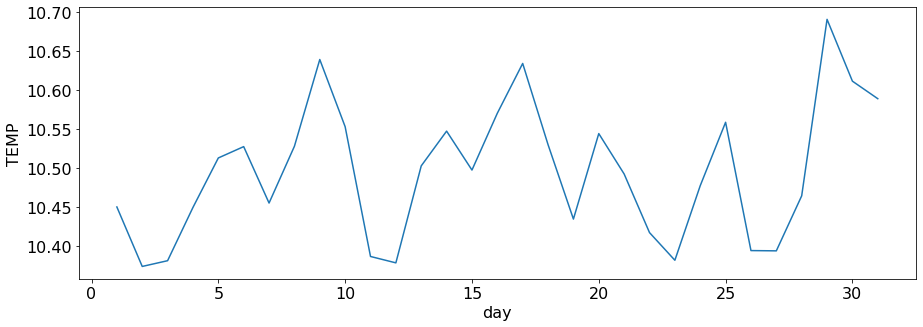

In [160]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams.update({'font.size': 16})
SAM500_m.TEMP.plot(x = 'day')